In [1]:
import os
import random
import time
from urllib.request import urlretrieve

import numpy as np
import cv2
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset

from aegear.model import EfficientUNet
from aegear.datasets import DetectionDataset, BackgroundWindowDataset, RandomPoissonNoise, CachedDetectionDataset
from aegear.utils import get_latest_model_path

In [2]:
def get_confidence(heatmap):
    b, _, _, w = heatmap.shape
    flat_idx = torch.argmax(heatmap.view(b, -1), dim=1)
    y = flat_idx // w
    x = flat_idx % w
    return heatmap[0, 0, y, x].item()

def overlay_heatmap_on_rgb(rgb_tensor, heatmap, alpha=0.5, centroid_color=(0, 1, 0)):
    """
    Overlay heatmap onto RGB image and draw a circle at the predicted centroid.
    
    Args:
        rgb_tensor: [3, H, W] tensor
        heatmap: [H, W] numpy array
        alpha: blending weight
        centroid_color: (R, G, B) tuple in range 0–1
    Returns:
        overlay: [H, W, 3] numpy image
    """
    rgb = rgb_tensor.permute(1, 2, 0).cpu().numpy()
    rgb = rgb * 0.229 + 0.485
    rgb = rgb.clip(0, 1)

    heatmap_color = plt.cm.hot(heatmap)[..., :3]
    overlay = (1 - alpha) * rgb + alpha * heatmap_color

    # Find centroid
    flat_idx = heatmap.reshape(-1).argmax()
    h, w = heatmap.shape
    cy = flat_idx // w
    cx = flat_idx % w

    # Draw circle
    overlay_uint8 = (overlay * 255).astype(np.uint8)
    cx_int, cy_int = int(cx), int(cy)
    color_bgr = tuple(int(c * 255) for c in reversed(centroid_color))
    cv2.circle(overlay_uint8, (cx_int, cy_int), 4, color_bgr, thickness=1)

    return overlay_uint8 / 255.0

def save_epoch_visualization(val_results, stage, epoch, output_dir="vis_epochs", N=5):
    os.makedirs(output_dir, exist_ok=True)

    # Sort by distance
    sorted_results = sorted(val_results, key=lambda r: r['confidence'], reverse=True)
    worst = sorted_results[-N:]
    best = sorted_results[:N]
    middle = sorted_results[len(sorted_results)//2 - N//2 : len(sorted_results)//2 + N//2]

    samples = worst[::-1] + middle + best  # worst at top, best at bottom
    total_rows = len(samples)

    _, axes = plt.subplots(total_rows, 3, figsize=(9, 3 * total_rows))

    for i, result in enumerate(samples):
        search = result['search']
        gt = result['gt_heatmap']
        pred = result['pred_heatmap']
        xg, yg = result['gt_centroid']
        xp, yp = result['pred_centroid']
        confidence = result['confidence']

        search_img = TF.to_pil_image(denormalize(search))
        search_np = TF.to_tensor(search_img).permute(1, 2, 0).numpy()

        # Normalize heatmaps
        pred_norm = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)
        gt_norm = (gt - gt.min()) / (gt.max() - gt.min() + 1e-8)
        diff_norm = np.abs(pred_norm - gt_norm)

        # Overlay prediction heatmap
        overlay = 0.6 * search_np + 0.4 * plt.cm.jet(pred_norm)[..., :3]
        overlay = np.clip(overlay, 0, 1)

        # Diff colormap
        diff_rgb = plt.cm.magma(diff_norm)[..., :3]

        # Plot
        axes[i, 0].imshow(overlay)
        axes[i, 0].scatter([xp], [yp], c='red', marker='x', label='Pred')
        axes[i, 0].scatter([xg], [yg], c='green', marker='o', label='GT')
        axes[i, 0].set_title(f"Search | Conf: {confidence:.2f}")
        axes[i, 0].legend()

        axes[i, 1].imshow(diff_rgb)
        axes[i, 1].set_title("Abs Diff")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    out_path = os.path.join(output_dir, f"stage_{stage:03d}_epoch_{epoch:03d}.png")
    plt.savefig(out_path)
    plt.close()

def save_epoch_activation_visualization(val_results, model, device, stage_n, epoch, output_dir="vis_activations", N=5, channels_per_stage=3):
    def get_activations(model):
        activations = {}

        def get_activation(name):
            def hook(model, input, output):
                activations[name] = output.detach().cpu()
            return hook

        model.enc1.register_forward_hook(get_activation('enc1'))
        model.enc2.register_forward_hook(get_activation('enc2'))
        model.enc3.register_forward_hook(get_activation('enc3'))
        model.enc4.register_forward_hook(get_activation('enc4'))
        model.enc5.register_forward_hook(get_activation('enc5'))

        model.up4.register_forward_hook(get_activation('up4'))
        model.up3.register_forward_hook(get_activation('up3'))
        model.up2.register_forward_hook(get_activation('up2'))
        model.up1.register_forward_hook(get_activation('up1'))
        model.up0.register_forward_hook(get_activation('up0'))

        model.out.register_forward_hook(get_activation('out'))

        return activations

    def denormalize(img_tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(img_tensor.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(img_tensor.device)
        return (img_tensor * std + mean).clamp(0, 1)

    os.makedirs(output_dir, exist_ok=True)

    activations = get_activations(model)

    # Sort by confidence
    sorted_results = sorted(val_results, key=lambda r: r['confidence'], reverse=True)
    worst = sorted_results[-N:]
    best = sorted_results[:N]
    middle = sorted_results[len(sorted_results)//2 - N//2 : len(sorted_results)//2 + N//2]

    samples = worst[::-1] + middle + best
    total_rows = len(samples)

    stages = ['enc1', 'enc2', 'enc3', 'enc4', 'enc5', 'up4', 'up3', 'up2', 'up1', 'up0', 'out']

    n_cols = 1 + channels_per_stage * len(stages)

    fig, axs = plt.subplots(total_rows, n_cols, figsize=(n_cols * 2.5, total_rows * 3))
    if total_rows == 1:
        axs = axs[None, :]  # force 2D

    model.eval()

    for row, sample in enumerate(samples):
        search = sample['search'].unsqueeze(0).to(device)
        xg, yg = sample['gt_centroid']
        xp, yp = sample['pred_centroid']
        confidence = sample['confidence']

        with torch.no_grad():
            _ = model(search)

        # Image and heatmap overlay
        img_np = denormalize(search[0]).permute(1, 2, 0).cpu().numpy()
        hm_np = sample['pred_heatmap'].numpy()

        overlay = img_np.copy()
        overlay[..., 0] = np.clip(overlay[..., 0] + 0.5 * hm_np, 0, 1)

        axs[row, 0].imshow(overlay)
        axs[row, 0].scatter([xg], [yg], c='green', marker='o', label='GT')
        axs[row, 0].scatter([xp], [yp], c='red', marker='x', label='Pred')
        axs[row, 0].set_title(f'Conf: {confidence:.2f}')
        axs[row, 0].axis('off')
        axs[row, 0].legend()

        # Activations per stage
        col = 1
        for stage in stages:
            act = activations[stage][0]  # single-sample activations

            for ch in range(channels_per_stage):
                if ch < act.shape[0]:
                    axs[row, col].imshow(act[ch].detach().cpu().numpy(), cmap='viridis')
                    axs[row, col].set_title(f'{stage} | Ch {ch}')
                else:
                    axs[row, col].axis('off')
                axs[row, col].axis('off')
                col += 1

    plt.tight_layout()
    out_path = os.path.join(output_dir, f"activation_stage_{stage_n:03d}_epoch_{epoch:03d}.png")
    plt.savefig(out_path, dpi=200)
    plt.close()

def denormalize(t):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    return t * std + mean

In [3]:
# 1. Device selection
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: cuda


In [ ]:
dataset_dir = "../data/training"
video_dir = "../data/video"

public_base_url = "https://storage.googleapis.com/aegear-training-data"

annotations = {
    "E7": {
        "file": 'tracking_E7_clean.json',
        "annotation_url": f"{public_base_url}/tracking/tracking_E7_clean.json",
        "video_url": f"{public_base_url}/video/E7.MOV"
    },
    "K9": {
        "file": 'tracking_K9_clean.json',
        "annotation_url": f"{public_base_url}/tracking/tracking_K9_clean.json",
        "video_url": f"{public_base_url}/video/K9.MOV"
    },
    "S1": {
        "file": 'tracking_S1_clean.json',
        "annotation_url": f"{public_base_url}/tracking/tracking_S1_clean.json",
        "video_url": f"{public_base_url}/video/S1.MOV"
    },
    "4_per_23": {
        "file": "tracking_4_per_23_clean.json",
        "annotation_url": f"{public_base_url}/tracking/tracking_4_per_23_clean.json",
        "video_url": f"{public_base_url}/video/4_per_23.MOV"
    },
    "5_per_12": {
        "file": "tracking_5_per_12_clean.json",
        "annotation_url": f"{public_base_url}/tracking/tracking_5_per_12_clean.json",
        "video_url": f"{public_base_url}/video/5_per_12.MOV"
    }
}

os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

bar = tqdm(annotations.items(), desc="Downloading from GCS")
for key, ann in bar:
    bar.set_postfix_str(key)

    annotations_file = os.path.join(dataset_dir, ann["file"])
    video_file = os.path.join(video_dir, f"{key}.MOV")

    if not os.path.exists(annotations_file):
        print(f"Downloading {ann['annotation_url']}")
        urlretrieve(ann["annotation_url"], annotations_file)

    if not os.path.exists(video_file):
        print(f"Downloading {ann['video_url']}")
        urlretrieve(ann["video_url"], video_file)

In [ ]:
interpolation_smoothness = 5.0

dataset_annotations = [os.path.join(dataset_dir, annotation_settings["file"]) for annotation_settings in annotations.values()]

augmentation_transforms = transforms.Compose([
    RandomPoissonNoise(p=0.15),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.05, 0.75)),
    transforms.ColorJitter(brightness=0.35, contrast=0.25, saturation=0.25, hue=0.15),
])

train_fraction = 0.9
train_dataset, val_dataset = DetectionDataset.build_split_datasets(
    dataset_annotations,
    video_dir,
    output_size=128,
    crop_size=256,
    train_fraction=train_fraction,
    temporal_jitter_range=5,
    center_offset_range=30,
    negative_sample_prob=0.0,
    gaussian_sigma=15.0,
    interpolation_smoothness=interpolation_smoothness,
    augmentation_transforms=augmentation_transforms,
    rotation_range=30.0,
    scale_range=0.3)

videos = [os.path.join(video_dir, f"{key}.MOV") for key in annotations.keys()]

# Background dataset
background_dataset = ConcatDataset([BackgroundWindowDataset(
    video_path,
    background_frames=list(range(500, 1000, 50)),
    output_size=128,
    crop_size=256,
    augmentation_transform=augmentation_transforms,
    rotation_range=30.0,
    scale_range=0.3) for video_path in videos])

# split background dataset into train and validation
train_background_size = int(len(background_dataset) * train_fraction)
val_background_size = len(background_dataset) - train_background_size
train_background_dataset, val_background_dataset = torch.utils.data.random_split(
    background_dataset,
    [train_background_size, val_background_size],
    generator=torch.Generator().manual_seed(42)
)

# Combine datasets
train_dataset = ConcatDataset([train_dataset, train_background_dataset])
val_dataset = ConcatDataset([val_dataset, val_background_dataset])

batch_size = 256
number_of_samples_per_epoch = 5000

sampler = torch.utils.data.RandomSampler(train_dataset, replacement=True, num_samples=number_of_samples_per_epoch)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

In [4]:
cache_dir = "../data/training/cache"

datasets = [
    "E7", "K9", "S1", "4_per_23", "5_per_12"
]

train_dataset = ConcatDataset([CachedDetectionDataset(os.path.join(cache_dir, name, "train")) for name in datasets])
val_dataset = ConcatDataset([CachedDetectionDataset(os.path.join(cache_dir, name, "val")) for name in datasets])

batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 105684
Validation dataset size: 2938


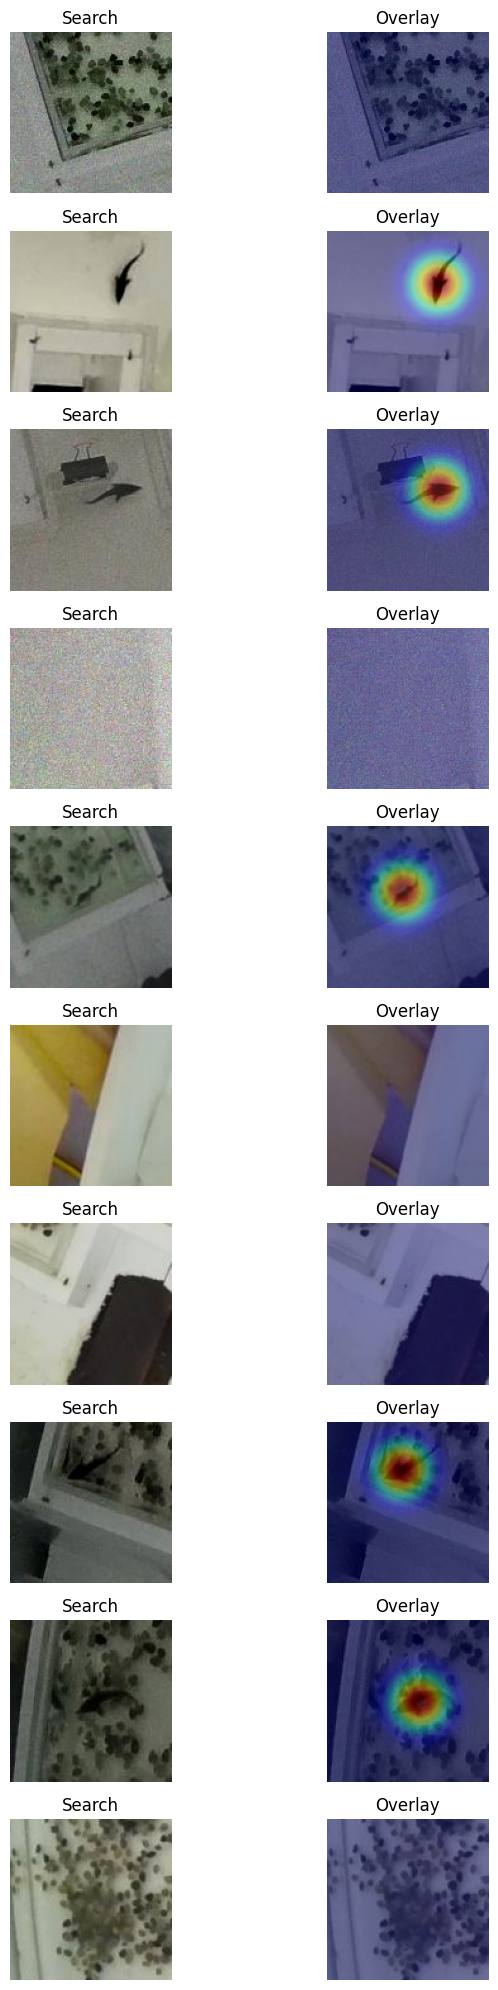

In [5]:
N = 10  # Number of samples to visualize

fig, axes = plt.subplots(N, 2, figsize=(8, 2 * N))

for i in range(N):
    random.seed(i)
    idx = random.randint(0, len(train_dataset) - 1)
    template, heatmap = train_dataset[idx]

    template_img = TF.to_pil_image(denormalize(template))
    heatmap_np = heatmap.squeeze().numpy()

    # === Normalize heatmap for display
    heatmap_norm = (heatmap_np - heatmap_np.min()) / (heatmap_np.max() - heatmap_np.min() + 1e-8)

    # === Blend
    search_np = TF.to_tensor(template_img).permute(1, 2, 0).numpy()
    heatmap_rgb = plt.cm.jet(heatmap_norm)[..., :3]
    overlay = 0.6 * search_np + 0.4 * heatmap_rgb
    overlay = np.clip(overlay, 0, 1)

    # === Plot
    axes[i, 0].imshow(template_img)
    axes[i, 0].set_title("Search")

    axes[i, 1].imshow(overlay)
    axes[i, 1].set_title("Overlay")

    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()

In [6]:
pretrained_model_dir = '../models/'

assert os.path.exists(pretrained_model_dir), "Pretrained model directory does not exist."

model_dir = '../data/training/models/efficient_unet'
log_dir = f'{model_dir}/runs'
checkpoint_dir = f'{model_dir}/checkpoints'
epoch_vis = f'{model_dir}/epoch_vis'

# Create directories if they don't exist
os.makedirs(model_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)
os.makedirs(epoch_vis, exist_ok=True)

In [10]:
def str2bool(val):
    return str(val).lower() in ("1", "true", "yes", "on")

# Model settings for training
continue_training =  str2bool(os.environ.get("CONTINUE_TRAINING", "false"))  # Continue training from the latest production model
use_best_model = str2bool(os.environ.get("USE_BEST_MODEL", "false"))  # If contnue_training is True, uses the cached best_model.pth, else uses the latest production model.

model = EfficientUNet(weights="IMAGENET1K_V1")

if continue_training:
   if use_best_model:
      # Load the best model
      best_model_path = os.path.join(model_dir, "best_model.pth")
      assert os.path.exists(best_model_path)

   else:     
      unet_model_filename = "model_efficient_unet"
      best_model_path = get_latest_model_path(pretrained_model_dir, unet_model_filename)

   print("Continuing training of the UNet model from:", best_model_path)
   model.load_state_dict(torch.load(best_model_path, map_location=device), strict=False)

else:
   print("Training a new UNet model from ImageNet weights.")

model.to(device)

# Freeze early layers
training_stages = [
   {
       "freeze_layers": [
            model.enc1,
            model.enc2,
            model.enc3,
            model.enc4,
            #model.enc5,
       ],
       #"epochs": 10,
       "epochs": 30,
       "lr": 1e-4,
   },
   {
       "freeze_layers": [
            model.enc1,
            model.enc2,
            model.enc3,
            model.enc4,
            model.enc5,
            model.up4,
            model.up3,
       ],
       #"epochs": 5,
       "epochs": 0,
       "lr": 5e-4,
   },
   {
       "freeze_layers": [
            model.enc1,
            model.enc2,
            model.enc3,
            model.enc4,
            model.enc5,
            model.up4,
       ],
       #"epochs": 5,
       "epochs": 0,
       "lr": 2.5e-4,
   },
   {
       "freeze_layers": [
            model.enc1,
            model.enc2,
            model.enc3,
            model.enc4,
       ],
       #"epochs": 10,
       "epochs": 0,
       "lr": 1e-4,
   },
]


Training a new UNet model from ImageNet weights.


In [11]:
def weighted_bce_with_logits(pred, target, limit=0.75, pos_weight=20.0):
    weights = torch.ones_like(target)
    weights[target > limit] = pos_weight  # emphasize center of Gaussian

    bce = F.binary_cross_entropy_with_logits(pred, target, weight=weights, reduction='mean')
    return bce

def get_centroids_per_sample(heatmap):
    b, _, _, w = heatmap.shape
    heatmaps = heatmap.squeeze(1)  # shape: [B, H, W]
    centroids = []

    for i in range(b):
        hm = heatmaps[i]
        hm_sum = hm.mean().item()

        if hm_sum < 1e-8:
            centroids.append(None)
        else:
            flat_idx = torch.argmax(hm)
            y = flat_idx // w
            x = flat_idx % w
            conf = hm[y, x]
            centroids.append((x.float(), y.float(), conf.float()))

    return centroids

def centroid_distance_loss(pred, target):
    preds = get_centroids_per_sample(torch.sigmoid(pred))
    targets = get_centroids_per_sample(target)

    distances = []

    for p, t in zip(preds, targets):
        if p is not None and t is not None:
            x_p, y_p, _ = p
            x_t, y_t, _ = t
            dist = torch.sqrt((x_p - x_t) ** 2 + (y_p - y_t) ** 2 + 1e-8)
            distances.append(dist)

    if not distances:
        return torch.tensor(0.0).to(pred.device), 0

    return torch.stack(distances).mean(), len(distances)


In [12]:
# Training loop
best_val_loss = float('inf')
losses = []

epoch_save_interval = 1
centroid_weight = 1e-3  # weight for centroid distance loss
sparsity_weight = 2.5e-4  # weight for sparsity loss

for stage, training_stage in enumerate(training_stages):

    freeze_layers = training_stage["freeze_layers"]
    epochs = training_stage["epochs"]

    for param in model.parameters():
        param.requires_grad = True

    for layer in freeze_layers:
        for param in layer.parameters():
            param.requires_grad = False

    optimizer = torch.optim.Adam(model.parameters(), lr=training_stage["lr"], weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5,
        patience=3,
    )

    for epoch in range(epochs):
        model.train()

        # Keep encoder in eval mode to avoid BN stat updates
        for layer in freeze_layers:
            layer.eval()

        train_loss = 0.0

        random.seed(time.time())
        train_bar = tqdm(train_loader, desc=f"Training stage {stage + 1}, epoch: {epoch + 1}", leave=False)
        for search, heatmap in train_bar:
            search = search.to(device)
            target = heatmap.to(device)

            output = model(search)

            mse = weighted_bce_with_logits(output, target)
            cdist, distances = centroid_distance_loss(output, target)
            sparsity_loss = output.pow(2).mean()

            loss = (
                mse
                + centroid_weight * cdist
                + sparsity_weight * sparsity_loss
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

        model.eval()
        val_loss = 0.0
        val_results = []  # NEW

        with torch.no_grad():
            random.seed(42)
            val_bar = tqdm(val_loader, desc=f"Validation stage {stage + 1}, epoch: {epoch + 1}", leave=False)

            for search, heatmap in val_bar:
                search = search.to(device)
                target = heatmap.to(device)

                output = model(search)

                mse = weighted_bce_with_logits(output, target)
                cdist, distances = centroid_distance_loss(output, target)
                sparsity_loss = output.pow(2).mean()

                loss = (
                    mse
                    + centroid_weight * cdist
                    + sparsity_weight * sparsity_loss
                )

                val_loss += loss.item()
                val_bar.set_postfix(loss=loss.item())

                # --------- COLLECT SAMPLE DATA ---------
                # Resize output and heatmap
                pred_resized = F.interpolate(torch.sigmoid(output), size=template.shape[-2:], mode='bilinear', align_corners=False)
                target_resized = F.interpolate(target, size=template.shape[-2:], mode='bilinear', align_corners=False)

                # Get centroids and confidence per sample
                centroids_pred = get_centroids_per_sample(pred_resized)
                centroids_gt = get_centroids_per_sample(target_resized)

                for i in range(search.size(0)):
                    p = centroids_pred[i]
                    t = centroids_gt[i]

                    if p is None or t is None:
                        continue  # skip bad samples

                    x_pred, y_pred, confidence = p
                    x_gt, y_gt, _ = t

                    xp, yp = x_pred.item(), y_pred.item()
                    xg, yg = x_gt.item(), y_gt.item()

                    dist = np.sqrt((xp - xg) ** 2 + (yp - yg) ** 2)

                    val_results.append({
                        'search': search[i].cpu(),
                        'gt_heatmap': target_resized[i, 0].cpu(),
                        'pred_heatmap': pred_resized[i, 0].cpu(),
                        'gt_centroid': (xg, yg),
                        'pred_centroid': (xp, yp),
                        'confidence': confidence.item(),
                        'distance': dist,
                    })

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        losses.append((train_loss, val_loss))

        scheduler.step(val_loss)

        save_epoch_visualization(val_results, stage, epoch, output_dir=epoch_vis, N=10)
        save_epoch_activation_visualization(val_results, model, device, stage, epoch, output_dir=epoch_vis, N=5)

        print(f"Epoch {epoch+1}/{epochs} - Train: {train_loss:.4f} | Val: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print("New best model, saving.")
            torch.save(model.state_dict(), f'{model_dir}/best_model.pth')

        if (epoch + 1) % epoch_save_interval == 0:
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_stage_{stage+1}_epoch_{epoch+1}.pth'))

Training stage 1, epoch: 1:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 1:   0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\relja\AppData\Local\Temp\ipykernel_43740\3514000549.py:69: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff_norm = np.abs(pred_norm - gt_norm)


Epoch 1/30 - Train: 0.7286 | Val: 0.6378
New best model, saving.


Training stage 1, epoch: 2:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 2:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2/30 - Train: 0.6085 | Val: 0.5771
New best model, saving.


Training stage 1, epoch: 3:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 3:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3/30 - Train: 0.5537 | Val: 0.5283
New best model, saving.


Training stage 1, epoch: 4:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 4:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4/30 - Train: 0.5079 | Val: 0.4879
New best model, saving.


Training stage 1, epoch: 5:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 5:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5/30 - Train: 0.4668 | Val: 0.4484
New best model, saving.


Training stage 1, epoch: 6:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 6:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6/30 - Train: 0.4316 | Val: 0.4144
New best model, saving.


Training stage 1, epoch: 7:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 7:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7/30 - Train: 0.4014 | Val: 0.3857
New best model, saving.


Training stage 1, epoch: 8:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 8:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8/30 - Train: 0.3755 | Val: 0.3656
New best model, saving.


Training stage 1, epoch: 9:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 9:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9/30 - Train: 0.3533 | Val: 0.3421
New best model, saving.


Training stage 1, epoch: 10:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 10:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10/30 - Train: 0.3350 | Val: 0.3272
New best model, saving.


Training stage 1, epoch: 11:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 11:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 11/30 - Train: 0.3202 | Val: 0.3145
New best model, saving.


Training stage 1, epoch: 12:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 12:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 12/30 - Train: 0.3074 | Val: 0.3007
New best model, saving.


Training stage 1, epoch: 13:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 13:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 13/30 - Train: 0.2973 | Val: 0.2951
New best model, saving.


Training stage 1, epoch: 14:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 14:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 14/30 - Train: 0.2892 | Val: 0.2848
New best model, saving.


Training stage 1, epoch: 15:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 15:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 15/30 - Train: 0.2822 | Val: 0.2812
New best model, saving.


Training stage 1, epoch: 16:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 16:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 16/30 - Train: 0.2769 | Val: 0.2757
New best model, saving.


Training stage 1, epoch: 17:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 17:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 17/30 - Train: 0.2728 | Val: 0.2723
New best model, saving.


Training stage 1, epoch: 18:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 18:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 18/30 - Train: 0.2698 | Val: 0.2678
New best model, saving.


Training stage 1, epoch: 19:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 19:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 19/30 - Train: 0.2673 | Val: 0.2662
New best model, saving.


Training stage 1, epoch: 20:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 20:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 20/30 - Train: 0.2649 | Val: 0.2649
New best model, saving.


Training stage 1, epoch: 21:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 21:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 21/30 - Train: 0.2635 | Val: 0.2633
New best model, saving.


Training stage 1, epoch: 22:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 22:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 22/30 - Train: 0.2619 | Val: 0.2655


Training stage 1, epoch: 23:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 23:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 23/30 - Train: 0.2618 | Val: 0.2625
New best model, saving.


Training stage 1, epoch: 24:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 24:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 24/30 - Train: 0.2611 | Val: 0.2634


Training stage 1, epoch: 25:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 25:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 25/30 - Train: 0.2600 | Val: 0.2627


Training stage 1, epoch: 26:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 26:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 26/30 - Train: 0.2602 | Val: 0.2598
New best model, saving.


Training stage 1, epoch: 27:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 27:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 27/30 - Train: 0.2598 | Val: 0.2637


Training stage 1, epoch: 28:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 28:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 28/30 - Train: 0.2598 | Val: 0.2615


Training stage 1, epoch: 29:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 29:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 29/30 - Train: 0.2601 | Val: 0.2599


Training stage 1, epoch: 30:   0%|          | 0/413 [00:00<?, ?it/s]

Validation stage 1, epoch: 30:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 30/30 - Train: 0.2600 | Val: 0.2601


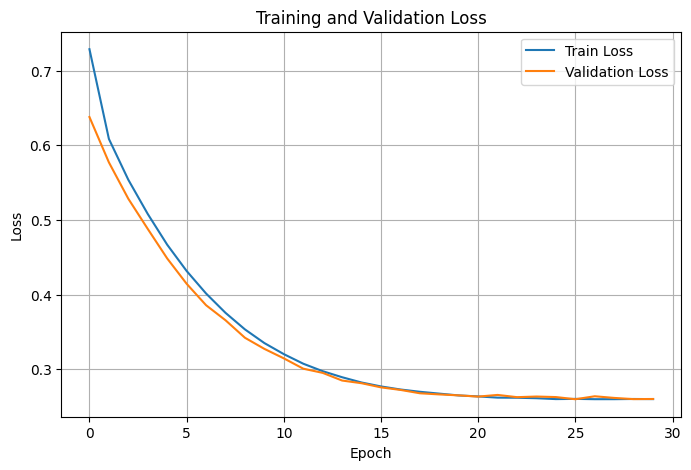

In [13]:
# Plotting the losses
import matplotlib.pyplot as plt

train_losses, val_losses = zip(*losses)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Load the best model for inference
model.load_state_dict(torch.load(f'{model_dir}/best_model.pth'))
model.eval()
model.to(device);

In [15]:
results = []
total_distances = []
total_confidences = []
within_radius = {r: 0 for r in [3, 5, 10]}
n_samples = 0

model.eval()

with torch.no_grad():
    for imgs, heatmaps in tqdm(val_loader, desc="Evaluating"):
        imgs = imgs.to(device)
        heatmaps = heatmaps.to(device)

        preds = torch.sigmoid(model(imgs))

        centroids_pred = get_centroids_per_sample(preds)
        centroids_gt = get_centroids_per_sample(heatmaps)

        for i in range(len(imgs)):
            p = centroids_pred[i]
            t = centroids_gt[i]

            if p is None or t is None:
                continue

            x_pred, y_pred, confidence = p
            x_gt, y_gt, _ = t

            xp, yp = x_pred.item(), y_pred.item()
            xg, yg = x_gt.item(), y_gt.item()
            confidence = confidence.item()

            dist = np.sqrt((xp - xg) ** 2 + (yp - yg) ** 2)
            total_distances.append(dist)
            total_confidences.append(confidence)

            for r in within_radius:
                if dist <= r:
                    within_radius[r] += 1
            n_samples += 1

            img = imgs[i].cpu()
            pred_hm = preds[i, 0].cpu()
            gt_hm = heatmaps[i, 0].cpu()

            results.append({
                'image': img,
                'gt_heatmap': gt_hm,
                'pred_heatmap': pred_hm,
                'gt_centroid': (xg, yg),
                'pred_centroid': (xp, yp),
                'confidence': confidence,
                'distance': dist,
            })

avg_dist = np.mean(total_distances)
avg_conf = np.mean(total_confidences)
print(f"\nAverage centroid distance: {avg_dist:.2f} px, Average confidence: {avg_conf:.2f}")

for r in sorted(within_radius):
    print(f"Within {r}px: {within_radius[r] / n_samples:.2%}")


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Average centroid distance: 2.77 px, Average confidence: 0.97
Within 3px: 70.63%
Within 5px: 90.48%
Within 10px: 97.80%


In [16]:
results.sort(key=lambda x: -x['distance'])  # descending


def show_sample(result, index=None):
    img = result['image']
    gt = result['gt_heatmap']
    pred = result['pred_heatmap']
    xg, yg = result['gt_centroid']
    xp, yp = result['pred_centroid']
    dist = result['distance']
    conf = result['confidence']

    gt_value_center = gt.numpy()[int(yg), int(xg)]
    p_value_center = pred.numpy()[int(yp), int(xp)]

    print(f"GT Value at center: {gt_value_center:.2f}, Pred Value at center: {p_value_center:.2f}")

    # Denormalize image for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_disp = img * std + mean
    img_disp = img_disp.clamp(0, 1).permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].imshow(img_disp)
    axs[0].scatter([xg], [yg], c='green', label='GT')
    axs[0].scatter([xp], [yp], c='red', label='Pred')
    axs[0].set_title(f'Image (Err: {dist:.1f}px, Conf: {conf:.2f})')
    axs[0].legend()

    axs[1].imshow(gt.numpy(), cmap='hot')
    axs[1].set_title('GT Heatmap')

    axs[2].imshow(pred.numpy(), cmap='hot')
    axs[2].set_title('Predicted Heatmap')

    if index is not None:
        fig.suptitle(f"Sample #{index}", fontsize=16)

    plt.tight_layout()
    plt.show()

GT Value at center: 1.00, Pred Value at center: 0.01


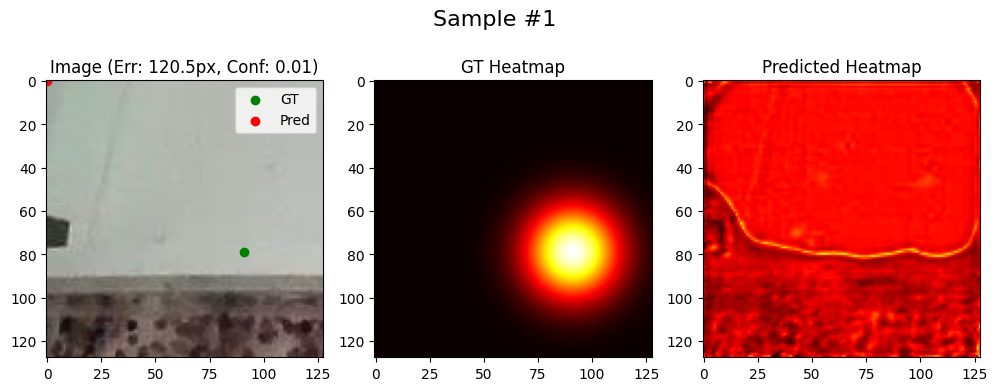

GT Value at center: 1.00, Pred Value at center: 0.87


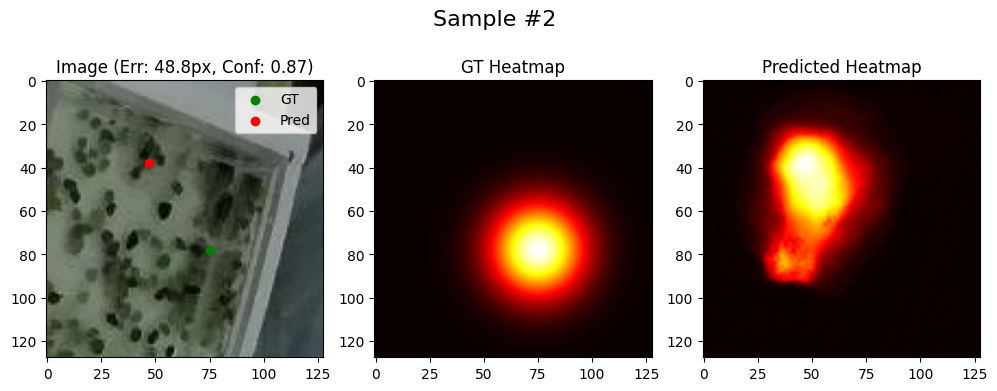

GT Value at center: 1.00, Pred Value at center: 0.97


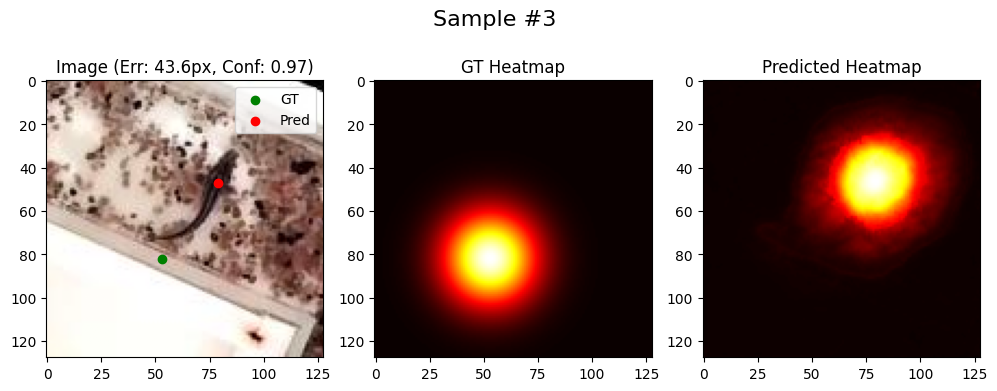

GT Value at center: 1.00, Pred Value at center: 0.94


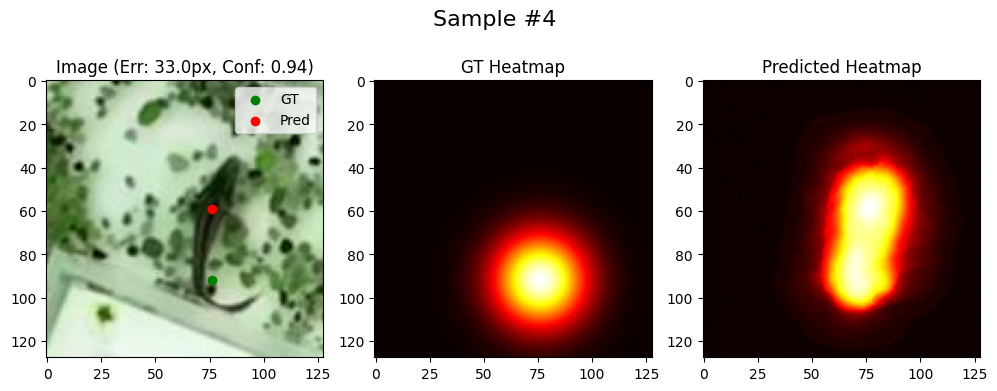

GT Value at center: 1.00, Pred Value at center: 0.95


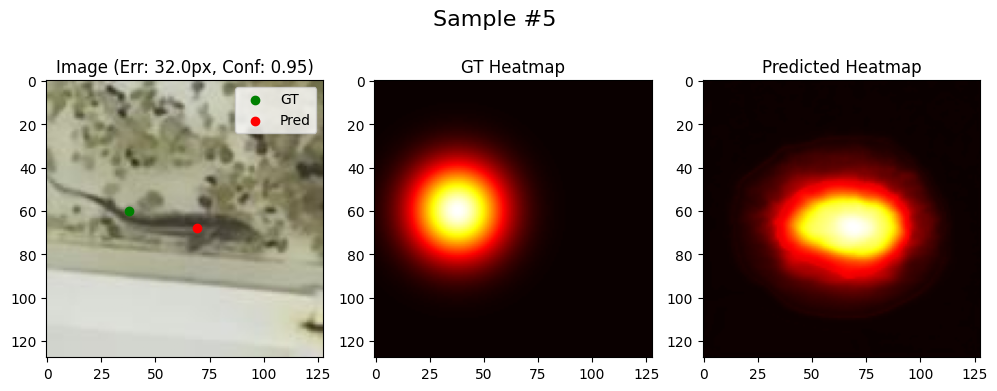

GT Value at center: 1.00, Pred Value at center: 0.90


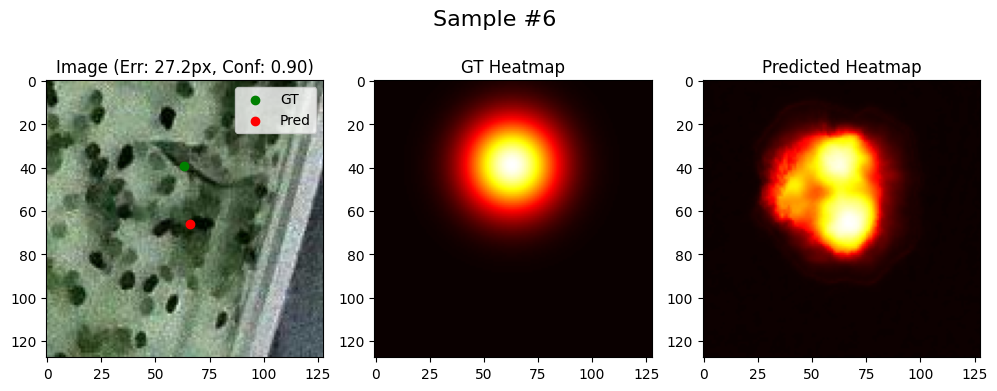

GT Value at center: 1.00, Pred Value at center: 0.97


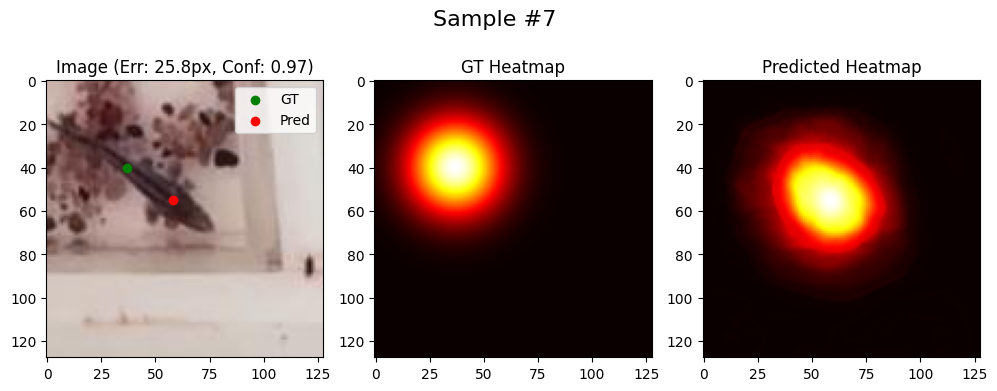

GT Value at center: 1.00, Pred Value at center: 0.81


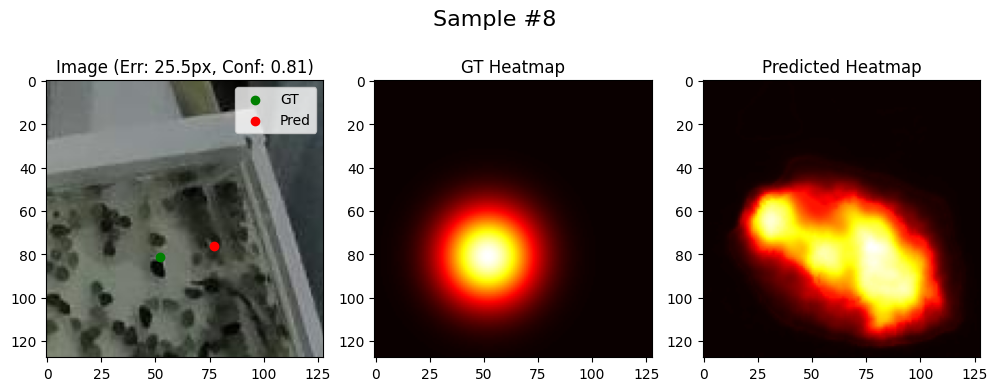

GT Value at center: 1.00, Pred Value at center: 0.97


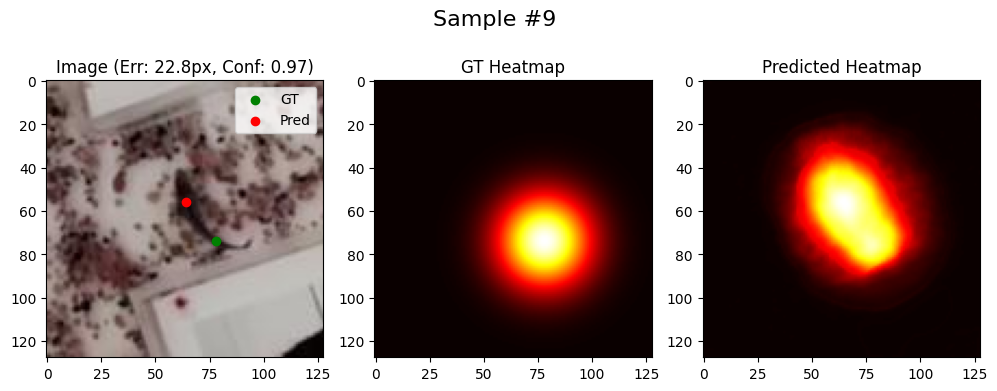

GT Value at center: 1.00, Pred Value at center: 0.94


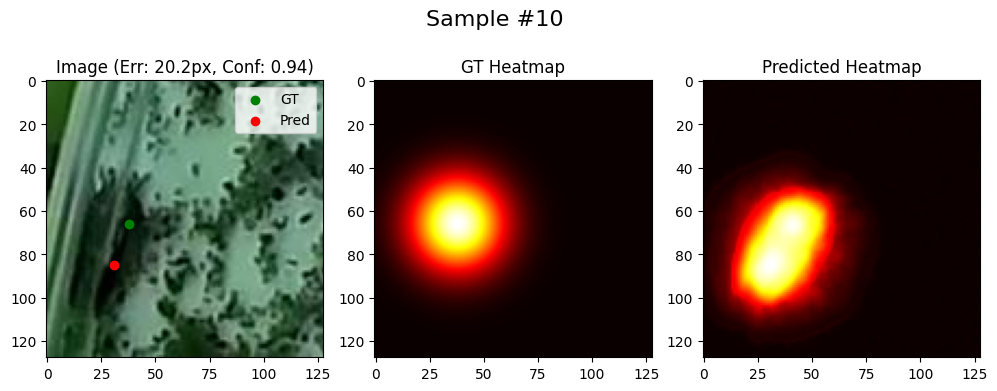

In [17]:
# Show some of the worst predictions
#
# The worst ones are expected to be the outliers in the
# dataset, as we know we have some bad labeling.
for i in range(10):
    show_sample(results[i], index=i+1)

GT Value at center: 1.00, Pred Value at center: 0.96


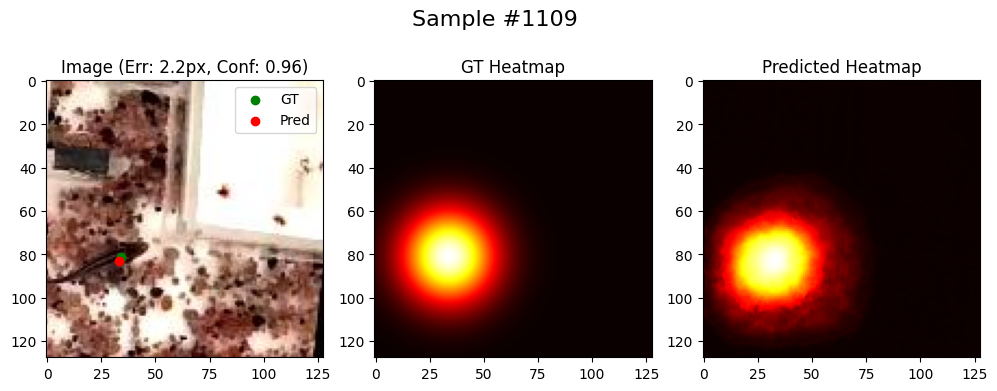

GT Value at center: 1.00, Pred Value at center: 0.98


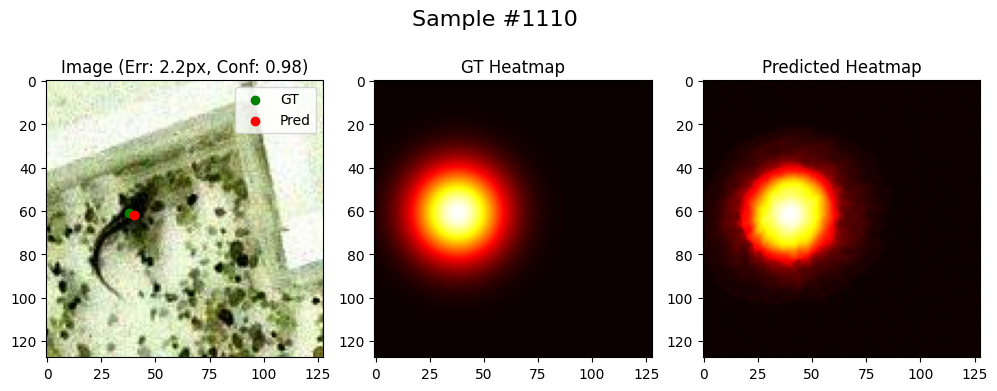

GT Value at center: 1.00, Pred Value at center: 0.98


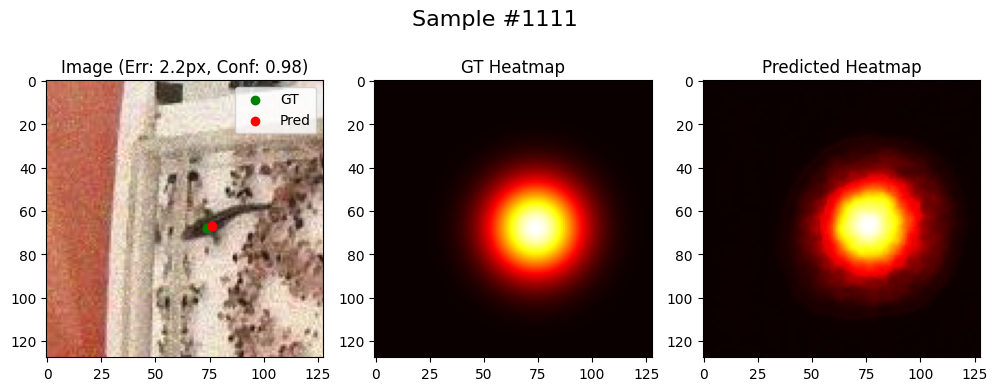

GT Value at center: 1.00, Pred Value at center: 0.95


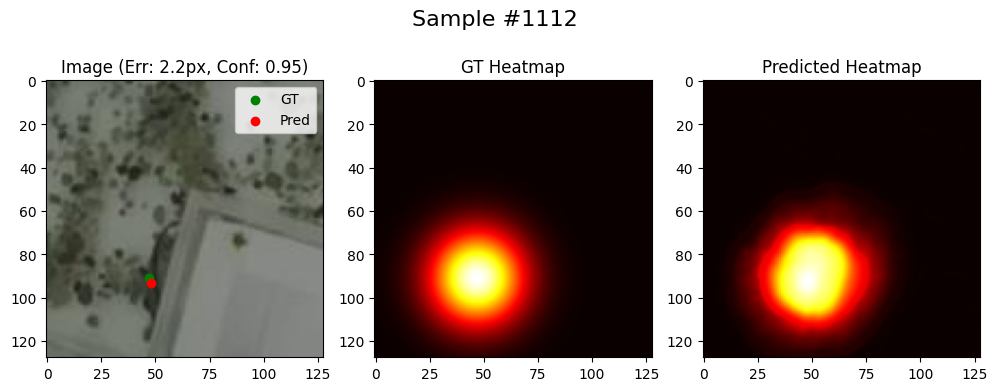

GT Value at center: 1.00, Pred Value at center: 0.97


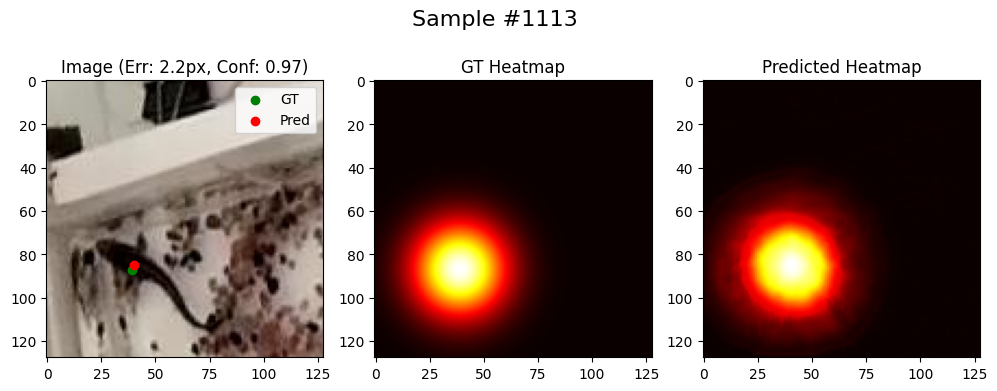

GT Value at center: 1.00, Pred Value at center: 0.96


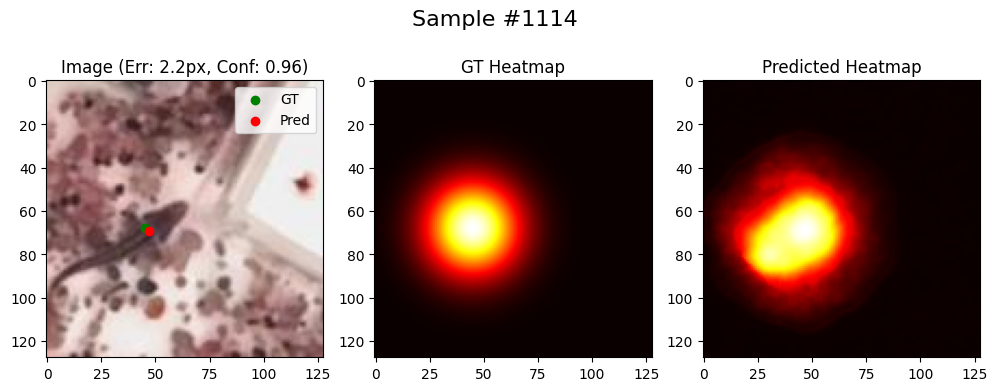

GT Value at center: 1.00, Pred Value at center: 0.97


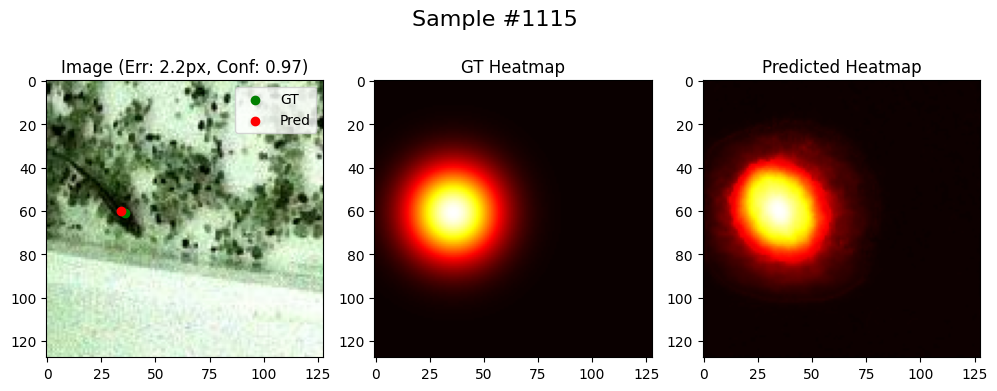

GT Value at center: 1.00, Pred Value at center: 0.96


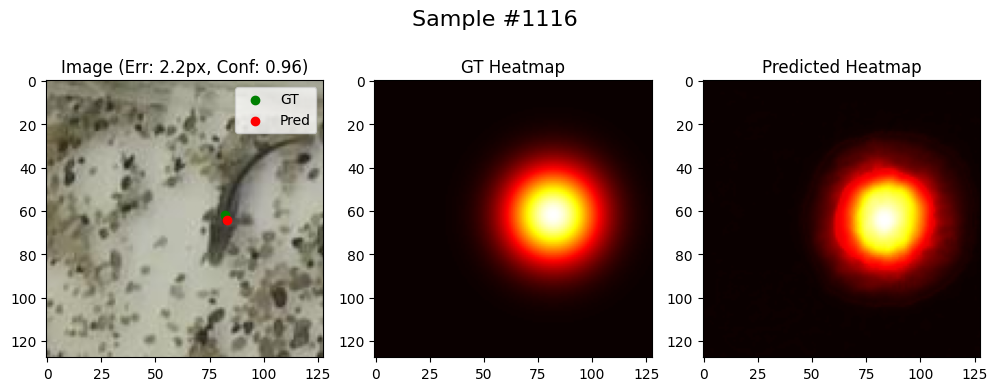

GT Value at center: 1.00, Pred Value at center: 0.98


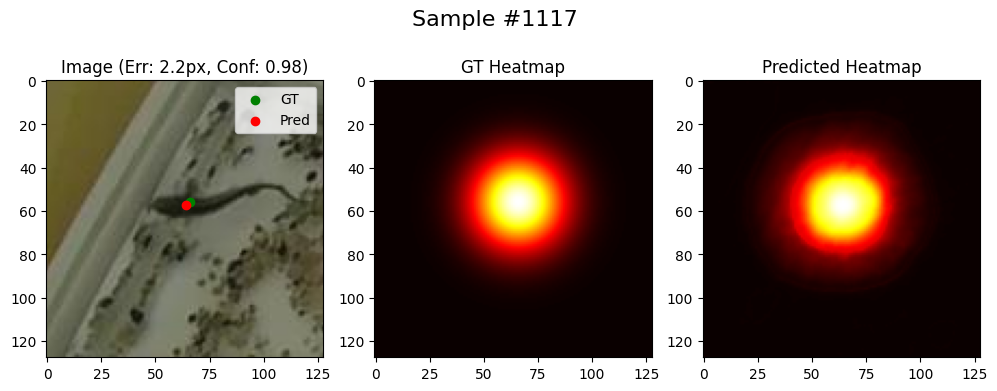

GT Value at center: 1.00, Pred Value at center: 0.96


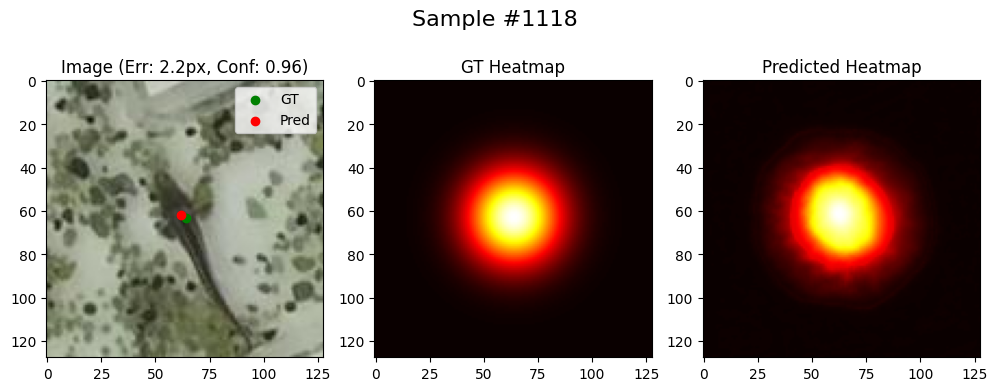

In [18]:
result_size = len(results)
# Show the middle ones
for i in range(result_size//2-5, result_size//2+5):
    show_sample(results[i], index=i+1)

GT Value at center: 1.00, Pred Value at center: 0.97


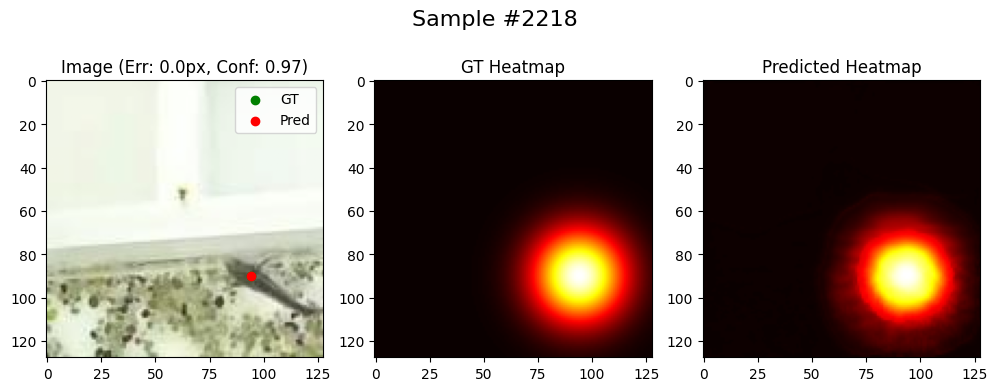

GT Value at center: 1.00, Pred Value at center: 0.98


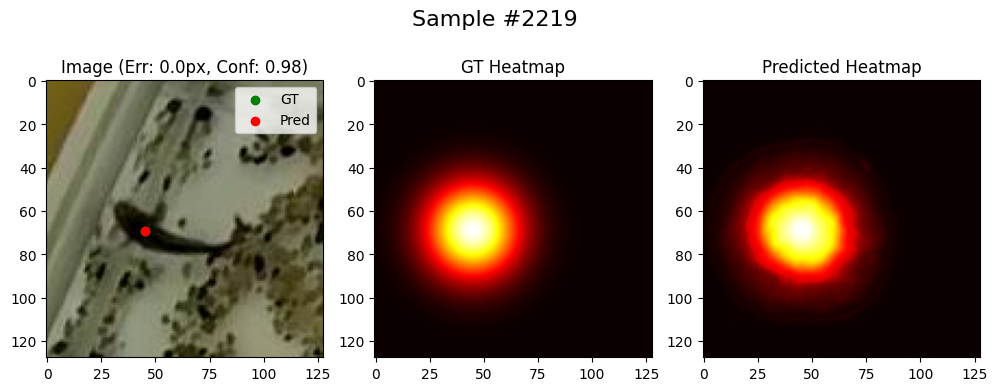

GT Value at center: 1.00, Pred Value at center: 0.96


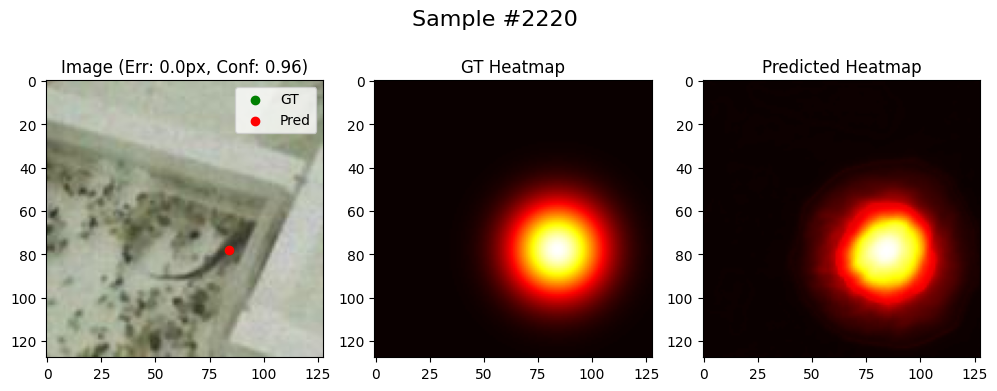

GT Value at center: 1.00, Pred Value at center: 0.95


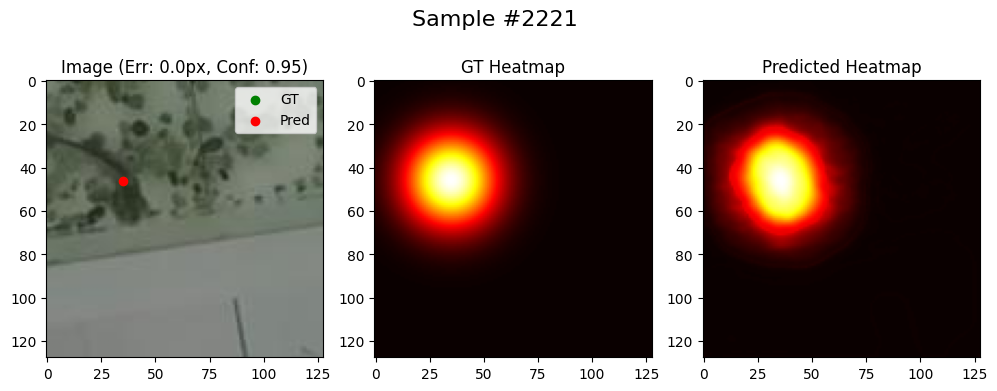

GT Value at center: 1.00, Pred Value at center: 0.98


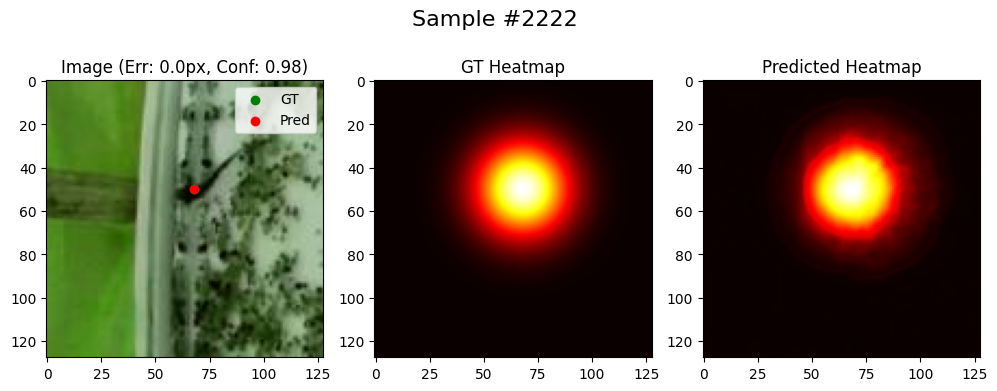

GT Value at center: 1.00, Pred Value at center: 0.98


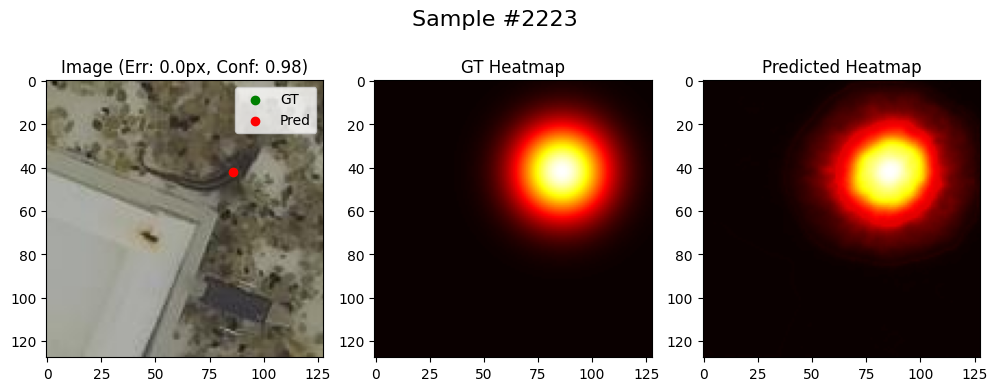

GT Value at center: 1.00, Pred Value at center: 0.96


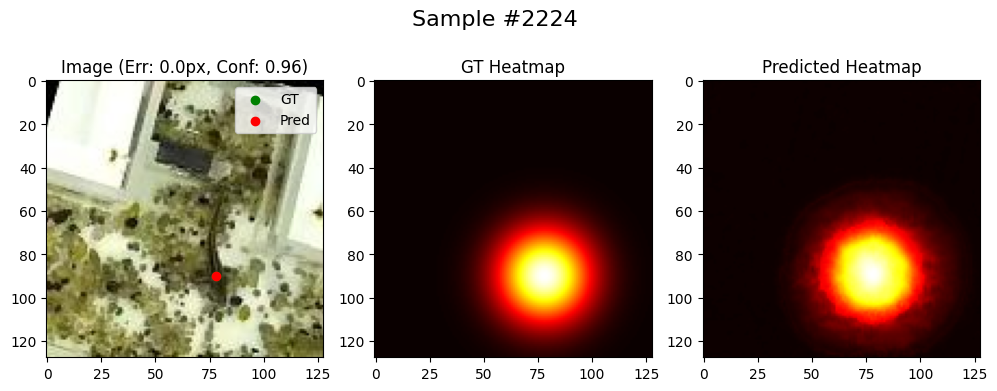

GT Value at center: 1.00, Pred Value at center: 0.97


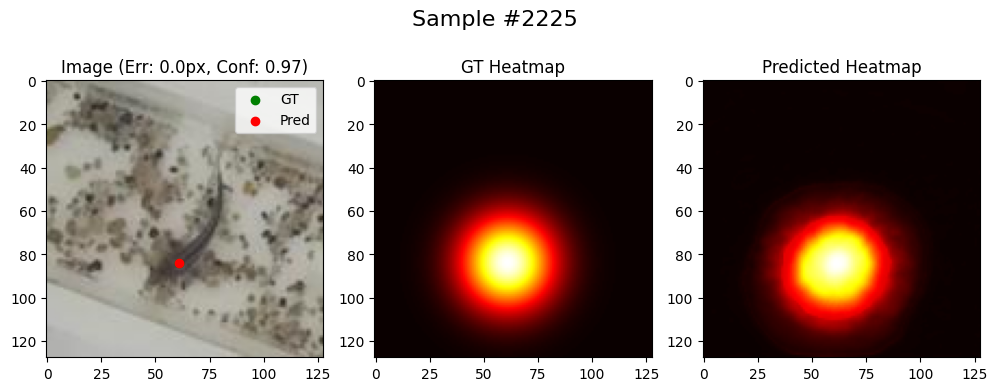

GT Value at center: 1.00, Pred Value at center: 0.97


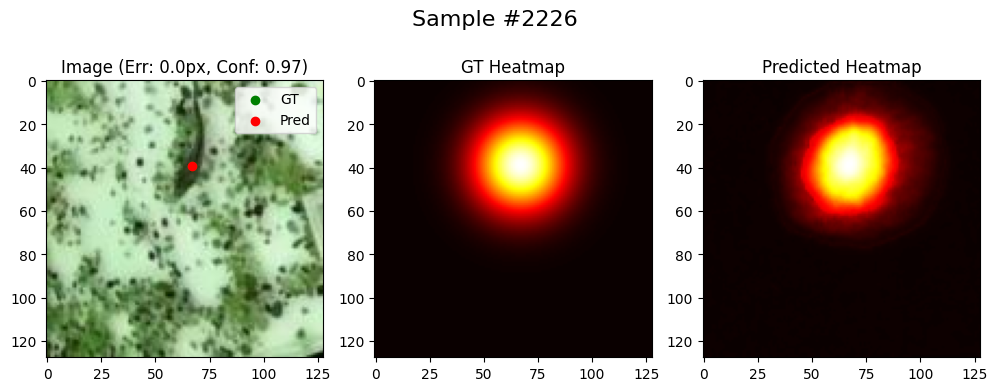

GT Value at center: 1.00, Pred Value at center: 0.96


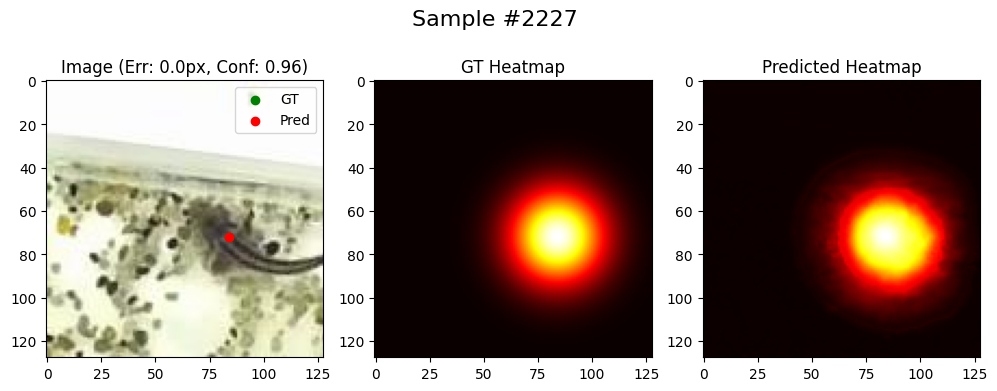

In [19]:
# Show some of the best predictions
for i in range(result_size-10, result_size):
    show_sample(results[i], index=i+1)